# Import data 

In [1]:
import boto3
import os
import boto3
import sagemaker
import pandas as pd
from scipy.io import arff
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')


In [2]:
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

In [3]:
data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])


In [4]:
class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

# Exploring data

In [5]:
df.shape

(310, 7)

In [6]:
df.columns

Index(['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class'],
      dtype='object')

In [7]:
df.dtypes

pelvic_incidence            float64
pelvic_tilt                 float64
lumbar_lordosis_angle       float64
sacral_slope                float64
pelvic_radius               float64
degree_spondylolisthesis    float64
class                         int64
dtype: object

In [8]:
df['pelvic_incidence'].describe()

count    310.000000
mean      60.496653
std       17.236520
min       26.147921
25%       46.430294
50%       58.691038
75%       72.877696
max      129.834041
Name: pelvic_incidence, dtype: float64

In [9]:
df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,0.677419
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.468220
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.000000
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.000000
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,1.000000
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,1.000000
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,1.000000


Matplotlib is building the font cache; this may take a moment.


<Axes: >

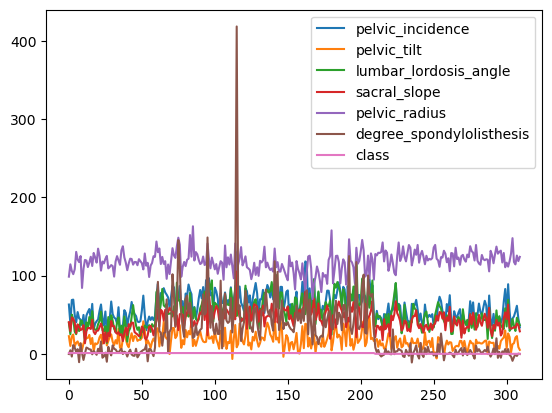

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
df.plot()

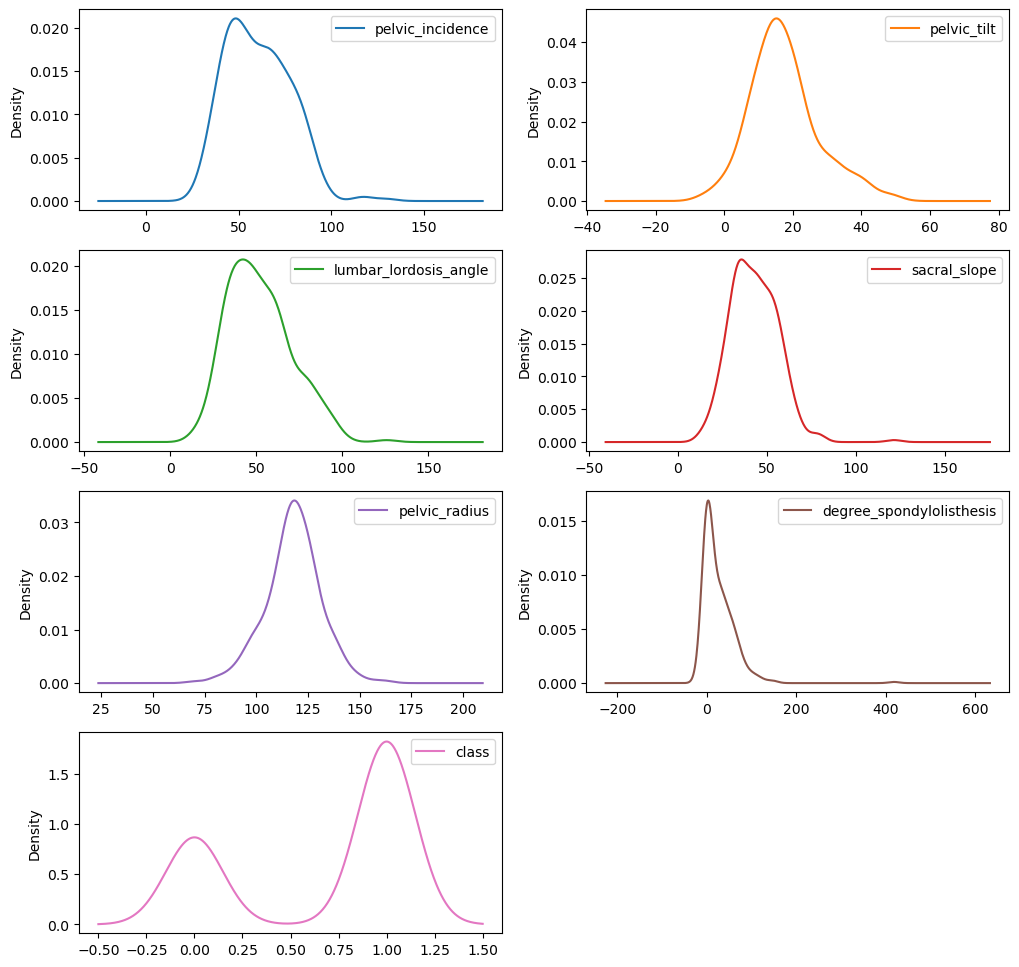

In [13]:
df.plot(kind='density',subplots=True,layout=(4,2),figsize=(12,12),sharex=False)
plt.show()

<Axes: ylabel='Density'>

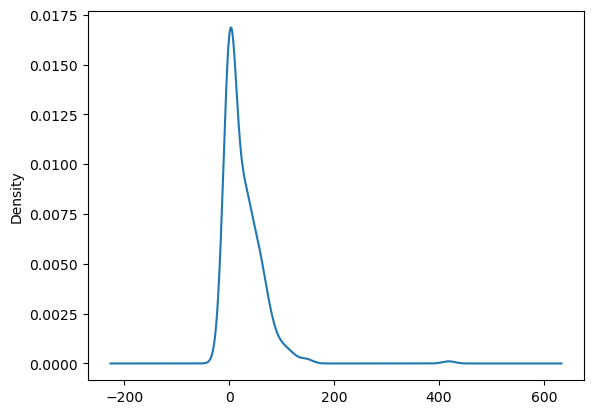

In [14]:
df['degree_spondylolisthesis'].plot.density()

<Axes: ylabel='Frequency'>

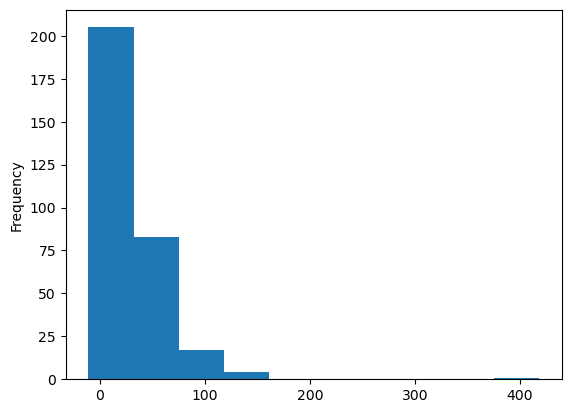

In [15]:
#check for outliners 
df['degree_spondylolisthesis'].plot.hist()

<Axes: >

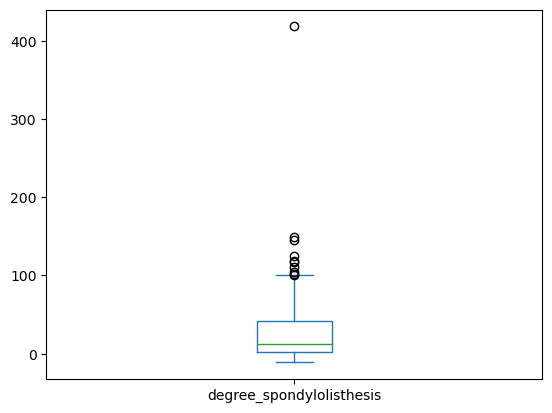

In [16]:
#small outliner near 400
df['degree_spondylolisthesis'].plot.box()

In [10]:
df['class'].value_counts()

class
1    210
0    100
Name: count, dtype: int64

<Axes: xlabel='class', ylabel='degree_spondylolisthesis'>

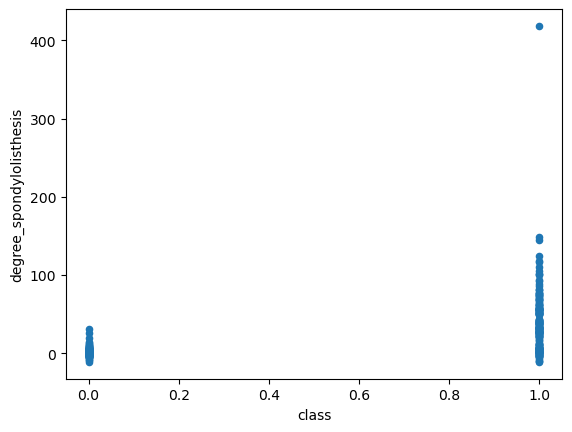

In [18]:
df.plot.scatter(y='degree_spondylolisthesis',x='class')

In [11]:
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [12]:
df.columns

Index(['class', 'pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis'],
      dtype='object')

# SPLIT THE DATA

In [13]:
from sklearn.model_selection import train_test_split
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])

In [14]:
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

In [15]:
print(train.shape)
print(test.shape)
print(validate.shape)

(248, 7)
(31, 7)
(31, 7)


In [16]:
print(train['class'].value_counts())
print(test['class'].value_counts())
print(validate['class'].value_counts())

class
1    168
0     80
Name: count, dtype: int64
class
1    21
0    10
Name: count, dtype: int64
class
1    21
0    10
Name: count, dtype: int64


## Uploading the data to Amazon S3

In [19]:
bucket='c86706a1848125l4258154t1w265295055383-labbucket-1n81otth44x80'
prefix='lab3'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

import os

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [20]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

# Step 3: Training the model

Now that the data in Amazon S3 
get the XGBoost container URI.

In [21]:
import boto3
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')


In [22]:
hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

In [23]:
import sagemaker
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

In [24]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [25]:
xgb_model.fit(inputs=data_channels, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-06-11-14-06-11-026



2023-06-11 14:06:11 Starting - Starting the training job...
2023-06-11 14:06:35 Starting - Preparing the instances for training..............
2023-06-11 14:07:49 Downloading - Downloading input data.....
2023-06-11 14:08:19 Training - Downloading the training image........
2023-06-11 14:09:05 Training - Training image download completed. Training in progress....
2023-06-11 14:09:25 Uploading - Uploading generated training model..
2023-06-11 14:09:41 Completed - Training job completed


In [26]:
print('ready for hosting!')

ready for hosting!


# Step 1: Hosting the model



In [27]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-06-11-14-09-50-712
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-06-11-14-09-50-712
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-06-11-14-09-50-712


-------!

# Step 2: Performing predictions
Now the model is deployed,run some predictions.

In [29]:
test.shape

(31, 7)

In [30]:
test.head(5)

,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,1,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,0,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,1,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,1,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,1,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958


In [31]:
row = test.iloc[0:1,1:]
row.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,88.024499,39.844669,81.774473,48.17983,116.601538,56.766083


In [32]:
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
print(test_row)


88.0244989,39.84466878,81.77447308,48.17983012,116.6015376,56.76608323



In [33]:
xgb_predictor.predict(test_row)

b'0.9966071844100952'

In [34]:
test.head(5)

,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,1,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,0,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,1,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,1,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,1,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958


In [36]:
batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()), sep=',', names=['class'])


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-06-11-14-23-03-429
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-06-11-14-23-04-119


..................................[2023-06-11:14:28:50:INFO] No GPUs detected (normal if no gpus installed)
[2023-06-11:14:28:50:INFO] No GPUs detected (normal if no gpus installed)
[2023-06-11:14:28:50:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-06-11 14:28:51 +0000] [19] [INFO] Starting g

In [37]:
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64


,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,1,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,0,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,1,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,1,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,1,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958


# Step 2: Creating a confusion matrix


In [38]:
test_labels = test.iloc[:,0]
test_labels.head()

136    1
230    0
134    1
130    1
47     1
Name: class, dtype: int64

In [39]:

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])

df_confusion

,Normal,Abnormal
Nnormal,7,3
Abnormal,2,19


INFO:matplotlib.font_manager:generated new fontManager


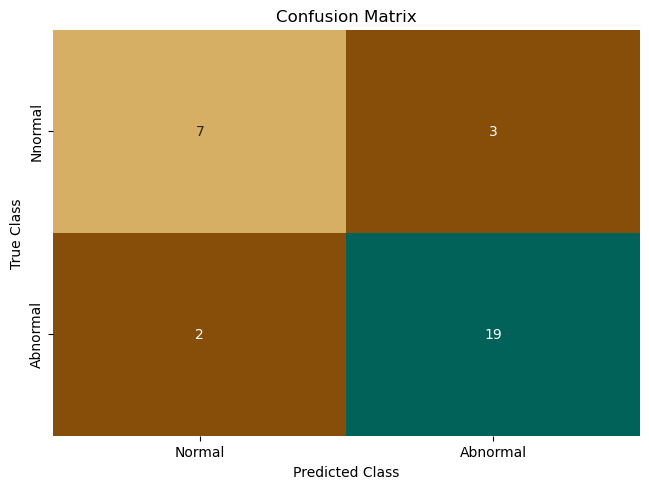

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

## Step 3: Calculating performance statistics

In [41]:

from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 7
False Positive (FP): 3
False Negative (FN): 2
True Positive (TP) : 19


### Sensitivity


In [42]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")

Sensitivity or TPR: 90.47619047619048%
There is a 90.47619047619048% chance of detecting patients with an abnormality have an abnormality


### Specificity


In [44]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")


Specificity or TNR: 70.0%
There is a 70.0% chance of detecting normal patients are normal.


### Positive and negative predictive values


In [45]:
# Precision or positive predictive value
#a higher precision is generally desired as it minimizes false positives
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")

Precision: 86.36363636363636%
You have an abnormality, and the probablity that is correct is 86.36363636363636%


In [46]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Negative Predictive Value: 77.77777777777779%
You don't have an abnormality, but there is a 77.77777777777779% chance that is incorrect


### False positive rate


In [47]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 30.0%
There is a 30.0% chance that this positive result is incorrect.


### False negative rate


In [48]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 9.523809523809524%
There is a 9.523809523809524% chance that this negative result is incorrect.


### False discovery rate


In [50]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 13.636363636363635%
You have an abnormality, but there is a 13.636363636363635% chance this is incorrect.


In [51]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 83.87096774193549%


In [52]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 90.47619047619048%
Specificity or TNR: 70.0%
Precision: 86.36363636363636%
Negative Predictive Value: 77.77777777777779%
False Positive Rate: 30.0%
False Negative Rate: 9.523809523809524%
False Discovery Rate: 13.636363636363635%
Accuracy: 83.87096774193549%


# Values to try try *.25* & *.75*. 



In [53]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted) )

Validation AUC 0.8904761904761904


#### The validation AUC value of 0.8904761904761904 indicates that the model has reasonably good performance in differentiating between positive and negative cases on the validation dataset. It suggests that the model has a relatively high true positive rate and a low false positive rate.

Figure(640x480)


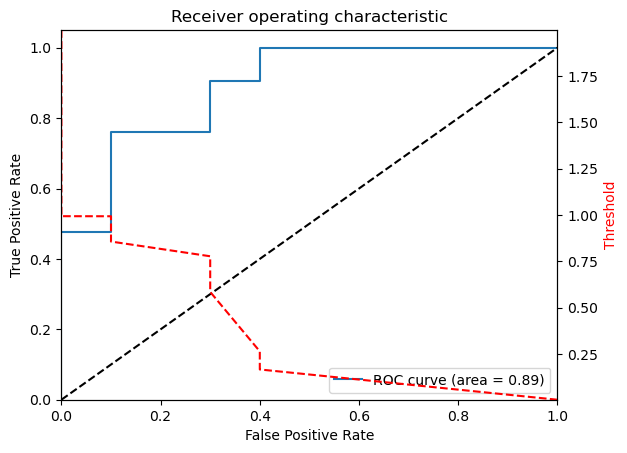

<Figure size 640x480 with 0 Axes>

In [54]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

print(plt.figure())

Figure(640x480)


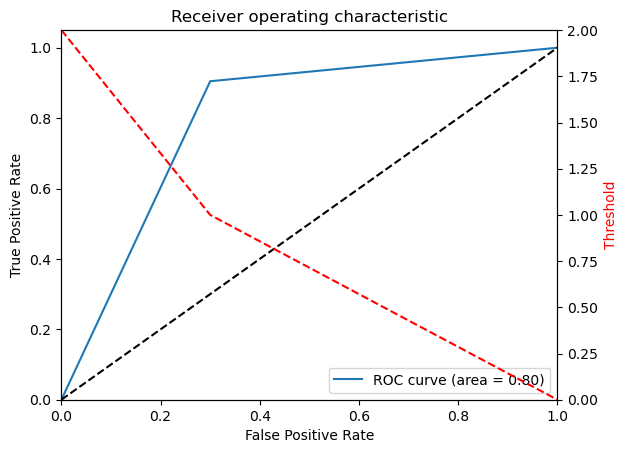

<Figure size 640x480 with 0 Axes>

In [55]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary )
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

print(plt.figure())

# Step 3: Terminating the deployed model


In [ ]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)